In [3]:
# import necessary packages
from pysheds.grid import Grid
import matplotlib.pyplot as plt
import numpy as np
import json
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoSeries
# set the font and font size for plots
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})


In [4]:

dem_tif = '/Users/shg096/Desktop/MERIT_Hydro_dem_BowAboveBanff.tif'




In [7]:
def dem_processing (dem_tif, dir_tif=None, dirmap = None, river_network_flush = False, pour_point = (0,0), threshold = 100):
    # Specify directional mapping
    if not dirmap:
        #N    NE    E    SE    S    SW    W    NW
        dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
    if not dir_tif:
        grid = Grid.from_raster(dem_tif, data_name='dem') # part of Missouri River
        grid.fill_depressions(data='dem', out_name='flooded_dem')
        grid.resolve_flats('flooded_dem', out_name='inflated_dem') #resolve the flats
        grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
        # Add new dir to grid as float
        grid.add_gridded_data(grid.dir.astype(float), data_name='dir_new', affine=grid.affine,
                              shape=grid.dem.shape, crs=grid.crs, nodata=grid.dem.nodata)
        grid.to_raster('dir_new', '../temporary/dir.tif' , view=False)
    else:
        grid = Grid.from_raster(dir_tif, data_name='dir') # part of Missouri River
    #
    grid.accumulation(data='dir', out_name='acc')
    if river_network_flush:
        xy = np.column_stack([pour_point[0], pour_point[1]])
        # putting the outlet point exactly on the river network
        new_xy = grid.snap_to_mask(grid.acc > 1000, xy, return_dist=False)
        new_xs, new_ys = new_xy[:,0], new_xy[:,1]
        # Delineate the catchment
        grid.catchment(data='dir', x=new_xs, y=new_ys, dirmap=dirmap, out_name='catch', nodata_in=255,
                       recursionlimit=1500000, xytype='label')
        grid.clip_to('catch') # must be clipped
        # Compute accumulation
        grid.accumulation(data='catch', out_name='acc')
        branches = None
        branches = grid.extract_river_network(fdir='catch', acc='acc', threshold=threshold, dirmap=dirmap)
        for branch in branches['features']:
            line = np.asarray(branch['geometry']['coordinates'])
        # dumpt the lines into a network
        with open('test.json', 'w') as json_file:
            json.dump(branches, json_file)
        # load the json and save it as a shapefile using geopandas
        A = gpd.read_file('test.json')
        # save the shapefile
        A.to_file('../temporary/river_netwrok.shp')

    
# dem_processing(dem_tif, dir_tif='../temporary/dir.tif', river_network_flush=True, pour_lon=-115.57, pour_lat=51.17 )

dem_processing(dem_tif, dir_tif='../temporary/dir.tif',\
               river_network_flush=True, pour_point=(-115.57,51.17) )



# branches = None
# branches = grid.extract_river_network(fdir='catch', acc='acc',
#                                       threshold=100000, dirmap=dirmap)



In [15]:
def river_network_topology(infile_river, outfile_network_topology, outfile_virtual_gauges):
    
    
    import geopandas as gpd
    import pandas as pd
    
    A = gpd.read_file(infile_river)

    # creat additional fields for network topology data
    A['start_lat'] = None
    A['start_lon'] = None
    A['end_lat']   = None
    A['end_lon']   = None
    A['end_lat_b'] = None
    A['end_lon_b'] = None
    A['ID']        = None
    A['Down_ID']   = None
    A['order']     = None
    A['Up_ID']     = None

    # popolating the fileds
    for index, row in A.iterrows():
        line = np.asarray(row['geometry'])
        # populate the filed
        A['start_lat'].loc[index] = line[-1,1] 
        A['start_lon'].loc[index] = line[-1,0] 
        A['end_lat'].loc[index]   = line[0,1] 
        A['end_lon'].loc[index]   = line[0,0] 
        A['end_lat_b'].loc[index] = line[1,1] # one before merged point not to include all the contributing area of confluence
        A['end_lon_b'].loc[index] = line[1,0] # one before merged point not to include all the contributing area of confluence
        A['ID'].loc[index]        = index + 1

        # print(A['end_lat_b'].iloc[index] , A['end_lon_b'].iloc[index])
    
    # create a list of immidiate downstream
    A['Down_ID'] = -9999
    for index, row in A.iterrows():
        # get the end lat, lon of a river segment
        end_lat = A['end_lat'].loc[index] 
        end_lon = A['end_lon'].loc[index] 
        # find which degment start with that lat, lon
        indy = A.index[A['start_lat'] == end_lat].tolist()
        indx = A.index[A['start_lon'] == end_lon].tolist()
        # find the ind of indy and indx
        ind = list(set(indy).intersection(indx))
        # assign the list of downstream segment to the field if no downstream -9999
        if str(ind).strip('[]') != '':
            A['Down_ID'].loc[index] = A['ID'].iloc[int(str(ind).strip('[]'))]
        else:
            A['Down_ID'].loc[index] = -9999

    # creat a list of immidiate upstream
    for index, row in A.iterrows():
        # get the ID of the river segment
        ID = A['ID'].loc[index] 
        # find the immidate upstream
        ind = A.index[A['Down_ID'] == ID]
        indup = A['ID'].iloc[ind].tolist()
        # assign the upstream list
        A['Up_ID'].loc[index] = str(indup)

    # save the shapefile
    A.to_file(outfile_network_topology)

    # save virtual gauges as points
    yc = A['end_lat_b']
    xc = A['end_lon_b']
    pts = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
    pts.to_file(outfile_virtual_gauges)
    

river_network_topology ('../temporary/river_netwrok.shp',
                       '../temporary/river_netwrok_NT.shp',
                       '../temporary/virtual_gauges.shp')

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

In [6]:
def river_network (dir_tif, acc_tif, river_shp):
    grid = Grid.from_raster(dir_tif, data_name='dir') # part of Missouri River
    grid = Grid.from_raster(acc_tif, data_name='acc') # part of Missouri River
    # Specify directional mapping
        #N    NE    E    SE    S    SW    W    NW
    dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
    branches = None
    branches = grid.extract_river_network(fdir='dir', acc='acc', threshold=100000, dirmap=dirmap)
    for branch in branches['features']:
        line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    # dumpt the lines into a network
    with open('test.shp', 'w') as json_file:
        json.dump(branches, json_file)
    # load the json and save it as a shapefile using geopandas
    A = gpd.read_file('test.shp')
    # save the shapefile
    A.to_file(river_shp)

river_network ('../temporary/dir.tif', '../temporary/acc.tif', '../temporary/river_shp.shp')

NameError: nodata value for 'dir' not found in instance.

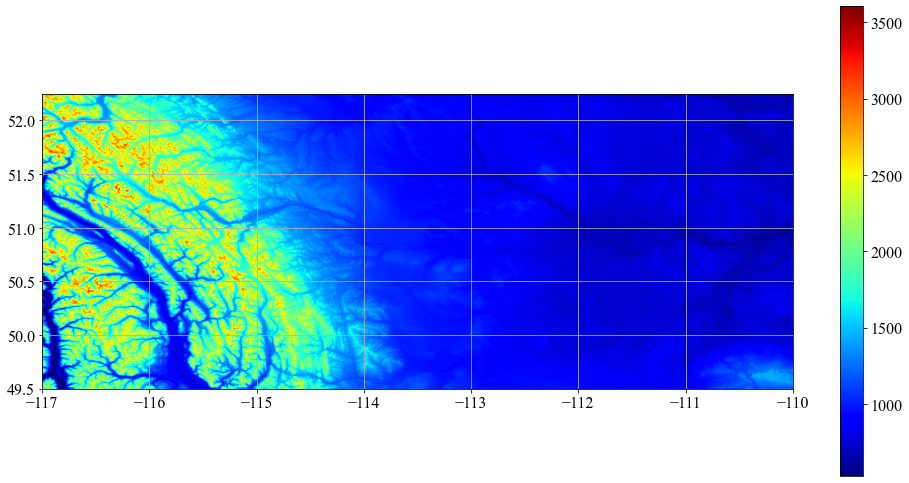

In [10]:
def visualize_tiff (geotiff_path, fig_size = (14,7), cmap='jet', colorbar_label = '', title ='', xlable = '',ylable=''):
    
    
    from pysheds.grid import Grid
    import matplotlib.pyplot as plt
    import numpy as np
    import json
    import geopandas as gpd
    from shapely.geometry import Point
    from geopandas import GeoSeries
    # set the font and font size for plots
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams.update({'font.size': 16})
    
    grid = Grid.from_raster(geotiff_path, data_name='temp') # part of Missouri River

    ID = np.where(grid.temp!=grid.temp.nodata) # the missing values is set to -9999 removing them from min and max for colorbar
    plt.figure(figsize = fig_size)
    plt.imshow(grid.temp.astype(float), extent=grid.extent, cmap=cmap, zorder=1,
               vmin=np.min(grid.temp[ID]), vmax=np.max(grid.temp[ID]))
    plt.colorbar(label=colorbar_label) # creating the colorbar and its name and unit
    plt.grid(zorder=0) # creating the grid on the map
    plt.title(title) # creating title
    plt.xlabel(xlable) #xlable which is long
    plt.ylabel(ylable) #ylable which is lat
    plt.tight_layout()

    
visualize_tiff ('/Users/shg096/Desktop/MERIT_Hydro_dem_BowAboveBanff.tif')

In [ ]:
def create_catchment (pour_lat, pour_lon, pour_point_correction):
    xy = np.column_stack([pour_lat, pour_lon])

    # putting the outlet point exactly on the river network
    new_xy = grid.snap_to_mask(grid.acc > 1000, xy, return_dist=False)
    new_xs, new_ys = new_xy[:,0], new_xy[:,1]

    # Delineate the catchment
    grid.catchment(data='dir', x=new_xs, y=new_ys, dirmap=dirmap, out_name='catch',
                   recursionlimit=15000, xytype='label')
    
    

In [ ]:
def create_river_network

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/candex/candex.py:1663: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stations_buffert = stations.buffer(buffer) # add a buffer


<AxesSubplot:>

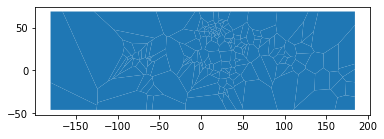

In [1]:
# loading candex
from candex.candex import candex
import geopandas

# initializing candex object
cndx = candex()

#point = gpd.read_file('../data/target_shapefiles/Capitals_point.shp')

shp = cndx.voronoi_diagram('../data/target_shapefiles/Capitals_point.shp', buffer=5)

shp.plot()


In [2]:
print(shp)

      ID                                           geometry   ID_s  \
0    NaN  POLYGON ((11.924 39.082, 12.664 42.921, 9.961 ...    1.0   
1    NaN  POLYGON ((14.864 43.640, 11.986 46.456, 9.897 ...    2.0   
2    NaN  POLYGON ((11.986 46.456, 9.897 44.545, 8.674 4...    3.0   
3    NaN  POLYGON ((4.305 48.862, 4.632 47.189, 8.283 49...    4.0   
4    NaN  POLYGON ((146.695 19.860, 164.424 31.199, 164....    5.0   
..   ...                                                ...    ...   
197  NaN  POLYGON ((21.761 28.591, 20.900 23.114, 22.179...  198.0   
198  NaN  POLYGON ((135.634 21.870, 132.089 27.920, 134....  199.0   
199  NaN  POLYGON ((4.305 48.862, 4.632 47.189, 3.961 45...  200.0   
200  NaN  POLYGON ((-124.540 -40.843, -123.926 -37.679, ...  201.0   
201  NaN  POLYGON ((95.211 -6.472, 110.516 -0.378, 108.4...  202.0   

             name  
0    Vatican City  
1      San Marino  
2           Vaduz  
3      Luxembourg  
4         Palikir  
..            ...  
197         Cairo  